# Lyrics-based Genre Classification - Training a classifier

Continuing from where we left off in the Preprocessing Notebook, we have a single csv file consisting of a Lyric column, containing the lyrics of each song, and three genre columns, corresponding to our one-hot encoded labels of Hip Hop, Pop and Rock. 

The link to the previous notebook is [https://www.kaggle.com/nkode611/lyricsgenreclassifier-datapreprocessing].

In this notebook we will perform some final transformations to our data in order to use it as imput to a Recurrent Neural Network. The network is a relatively simple one consisting of an LSTM layer, and aims to assign a genre to each song judging solely by its lyrics. 

In [1]:
# Import dependencies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lyricsgenreclassifier-datapreprocessing/__results__.html
/kaggle/input/lyricsgenreclassifier-datapreprocessing/__notebook__.ipynb
/kaggle/input/lyricsgenreclassifier-datapreprocessing/DF_3Genres_Lyrics_En.csv
/kaggle/input/lyricsgenreclassifier-datapreprocessing/__output__.json
/kaggle/input/lyricsgenreclassifier-datapreprocessing/custom.css


As said, we are using the output .csv dataframe from the preprocessing notebook as our data here. We can read from it as such:

In [2]:
df = pd.read_csv('../input/lyricsgenreclassifier-datapreprocessing/DF_3Genres_Lyrics_En.csv')
df.head()

,Lyric,Hip Hop,Pop,Rock
0,I could feel at the time. There was no way of ...,0,0,1
1,"Take me now, baby, here as I am. Hold me close...",0,0,1
2,These are. These are days you'll remember. Nev...,0,0,1
3,"A lie to say, ""O my mountain has coal veins an...",0,0,1
4,Trudging slowly over wet sand. Back to the ben...,0,0,1


### Cleaning up the text

We are going to use tensorflow to compile an LSTM based deep neural network. 

In order to feed in our lyrics as input there are a few primary steps to be taken so that we clean up our text.
1. We discard any punctuation from our text. We do this through the *string* package.
2. We split the text into separate words on whitespace. We use *re* for this.
3. We discard all english stopwords found in the text. We do this by loading the list of english stopwords from *nltk*.

We can define the folowing function to do all that:

In [3]:
# Function to clean and tokenize data
import nltk
import re
import string

stopwords = nltk.corpus.stopwords.words('english')

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [word for word in tokens if word not in stopwords]
    return text

Now we implement our *clean_text* function on the Lyric column:

In [4]:
# Get features as cleaned and tokenized words in the lyrics
df['Clean'] = df['Lyric'].apply(lambda x: clean_text(x))

Now we can assign our cleaned lyrics as our features, X. 

*Note: By "clean" lyrics I mean cleaned from punctuation and stopwords, there's probably a few dirty words in there...*

In [5]:
X=df.Clean
X.head()

0    [could, feel, time, way, knowing, fallen, leav...
1    [take, baby, hold, close, try, understand, des...
2    [days, youll, remember, never, never, since, p...
3    [lie, say, mountain, coal, veins, beds, dig, 5...
4    [trudging, slowly, wet, sand, back, bench, clo...
Name: Clean, dtype: object

Let's also make the labels dataframe from our one-hot encoded genre columns.

In [6]:
y = df.drop(['Lyric','Clean'], axis=1)
y.head()

,Hip Hop,Pop,Rock
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


Now we perform the classic train/test split method to obtain a training and a test set.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(77856,) (77856, 3)
(8651,) (8651, 3)


### Tokenizing our features

In order to use our features as input to the model we will compile, we need to tokenize them using the appropriate functions from keras. We will fit the tokenizer on the training values.

In [8]:
# Import the tools we will need from keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.values)

We must select a standard length for our input data. After going through a few examples, it seems that a length of 200 is a reasonable compromise. Now we either cut the lyrics short to 200 words, or zero pad them to reach that number.

In [15]:
X_train = tokenizer.texts_to_sequences(X_train.values)
X_train = pad_sequences(X_train, maxlen = 200)
print('Shape of data tensor:', X_train.shape)
print('Shape of label tensor:', y_train.shape)

Shape of data tensor: (77856, 200)
Shape of label tensor: (77856, 3)


Now that we have our data tensor ready we can define a few parameters necessary for the RNN design. These all essentially stem from the data tensor we have generated

In [16]:
import keras.backend as K
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential

VOCABULARY = len(tokenizer.index_word)+1
HIDDEN_SIZE = 32
INPUT_LENGTH = X_train.shape[1]
NUM_CLASSES = 3

### Designing a neural network

Let's design an LSTM RNN network

In [17]:
model = Sequential()

model.add(Embedding(VOCABULARY, HIDDEN_SIZE, input_length=INPUT_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_SIZE, dropout=0.4))
model.add(Dense(HIDDEN_SIZE, kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           4650080   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 4,659,555
Trainable params: 4,659,555
Non-trainable params: 0
_________________________________________________________________


This model is rather simple as far as LSTMs go, but after going through a few different configurations, it seemed to do as good a job as any in this task, so I went for the best result using the fewest resources. Let's compile it now.

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Training

Now the training process. We can set up the epochs, batch size and a validation split.

In [19]:
epochs = 5
batch_size = 256

history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.2,
                    )

Epoch 1/5
244/244 [==============================] - 59s 234ms/step - loss: 0.9133 - accuracy: 0.5718 - val_loss: 0.6664 - val_accuracy: 0.7097
Epoch 2/5
244/244 [==============================] - 56s 231ms/step - loss: 0.6310 - accuracy: 0.7312 - val_loss: 0.6243 - val_accuracy: 0.7317
Epoch 3/5
244/244 [==============================] - 57s 232ms/step - loss: 0.5379 - accuracy: 0.7782 - val_loss: 0.6287 - val_accuracy: 0.7353
Epoch 4/5
244/244 [==============================] - 56s 230ms/step - loss: 0.4753 - accuracy: 0.8073 - val_loss: 0.6549 - val_accuracy: 0.7318
Epoch 5/5
244/244 [==============================] - 57s 234ms/step - loss: 0.4297 - accuracy: 0.8273 - val_loss: 0.6751 - val_accuracy: 0.7187


Now to visualize the training process:

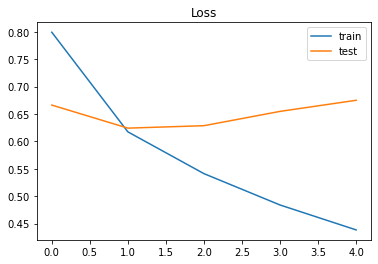

In [20]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

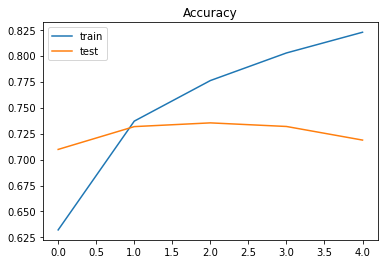

In [21]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

Even at 5 epochs short, all evidence points to the model overfitting. This seems to be the limit for our classifier. It's time to see if this performance is a reliable indicator of the classifier's capabilities.

### Testing on unseen data

We will use the test split data. First we have to tokenize it using our pre-fit tokenizer.

In [22]:
X_test = tokenizer.texts_to_sequences(X_test.values)
X_test = pad_sequences(X_test, maxlen = INPUT_LENGTH)

In [23]:
print('Shape of test data tensor:', X_test.shape)

Shape of test data tensor: (8651, 200)


The evaluation process:

In [24]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

271/271 [==============================] - 6s 21ms/step - loss: 0.6602 - accuracy: 0.7266
Test set
  Loss: 0.660
  Accuracy: 0.727


An accuracy of 72% is in line with the training results. Although far from a perfect classifier, at least we have something consistent.

### Confusion Matrix

We can take the followint steps to obtain a confusion matrix, which can give us some insights on the classification performance.

In [25]:
# Make predictions on test data
y_pred = model.predict(X_test)

In [26]:
# Get arrays from labels
predictions = np.argmax(y_pred, axis = 1)
labels = np.argmax(y_test.values, axis = 1)

<Figure size 432x288 with 0 Axes>

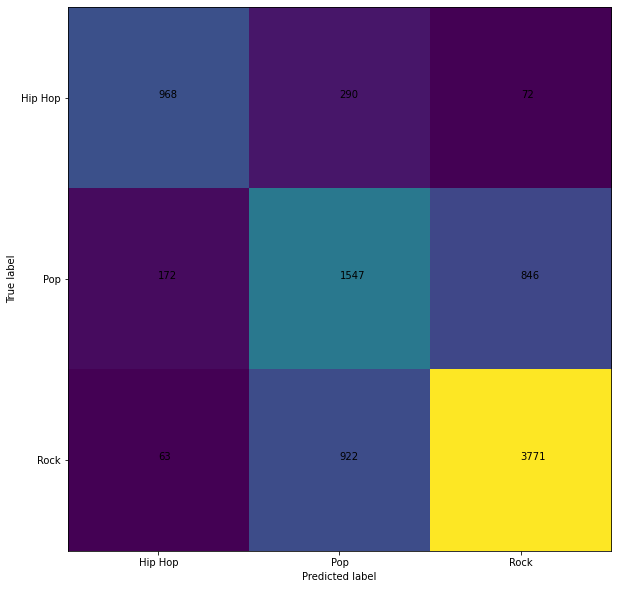

In [27]:
from sklearn.metrics import confusion_matrix

# Populate the confusion matrix using the label arrays
cm = confusion_matrix(labels, predictions)

# Generate plot
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest')
classNames = ['Hip Hop','Pop', 'Rock']
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
for i in range(3):
    for j in range(3):
        plt.text(j,i, str(cm[i][j]))
plt.show()

Here we have a confusion matrix. We can see that Hip Hop and Rock are relatively easy to distinguish, but Pop seems to blend in with the other genres, especially Rock.

At this point we have to take a step back from the pure numbers and think. How easy really is it to distinguish a Pop from a Rock song judging purely from their lyrical content? There has always been a big overlap between the two genres, and labelling certain artists or songs as either Pop or Rock is a rather nebulous affair. 

Therefore, it is reasonable to conclude that the model has done an adequate job at its task, considering all limitations, that may be comparable to the distinguishing ability of a human.  

In [28]:
# Save our trained model
model.save('LSTM_3Genre_Classifier.h5')